In [5]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Step 1: Load CIFAR-10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Step 2: Convert labels to one-hot
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [8]:
# Step 3: Create ImageDataGenerators (resizing on-the-fly)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Step 4: Flow training data through the generator
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow(
    x_test, y_test,
    batch_size=32,
    shuffle=False
)

val_generator = val_datagen.flow(
    x_val, y_val,
    batch_size=32,
    shuffle=False
)

In [9]:
# Step 5: Define ResNet50 base model (no top), input shape (224, 224, 3)
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Step 6: Freeze the base model
base_model.trainable = False

In [10]:
# Step 7: Add custom classification head
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [11]:
def resized_generator(generator):
    for batch_x, batch_y in generator:
        batch_x_resized = tf.image.resize(batch_x, (224, 224))  # Resize on-the-fly
        yield batch_x_resized, batch_y

train_resized_gen = resized_generator(train_generator)
# test_resized_gen = resized_generator(test_generator)
val_resized_gen = resized_generator(val_generator)

# Step 10: Train
steps_per_epoch = len(x_train) // 32
validation_steps = len(x_val) // 32

In [12]:
# Step 8: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# create a callback to save the best weights during training
checkpointer = ModelCheckpoint(filepath='aug_model.weights.h5', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(
    train_resized_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_resized_gen,
    validation_steps=validation_steps,
    callbacks=[checkpointer],
    epochs=10
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6815 - loss: 0.9635
Epoch 1: val_loss improved from inf to 0.35935, saving model to aug_model.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 173s 126ms/step - accuracy: 0.6815 - loss: 0.9633 - val_accuracy: 0.8759 - val_loss: 0.3593
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7945 - loss: 0.5847
Epoch 2: val_loss improved from 0.35935 to 0.35092, saving model to aug_model.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 127ms/step - accuracy: 0.7945 - loss: 0.5847 - val_accuracy: 0.8766 - val_loss: 0.3509
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8082 - loss: 0.5602
Epoch 3: val_loss improved from 0.35092 to 0.32921, saving model to aug_model.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 159ms/step - accuracy: 0.8082 - loss: 0.5602 - val_accuracy: 0.8854 - val_loss: 0.3292
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8140 - loss: 0.5433
Epoch 4:

In [10]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.h5')

In [11]:
# Evaluate on resized test set
test_generator = resized_generator(test_generator)
steps = len(x_test) // 32
loss, acc = model.evaluate(test_generator, steps=steps)
print("Test accuracy:", acc)

312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.9055 - loss: 0.2918
Test accuracy: 0.9049479365348816


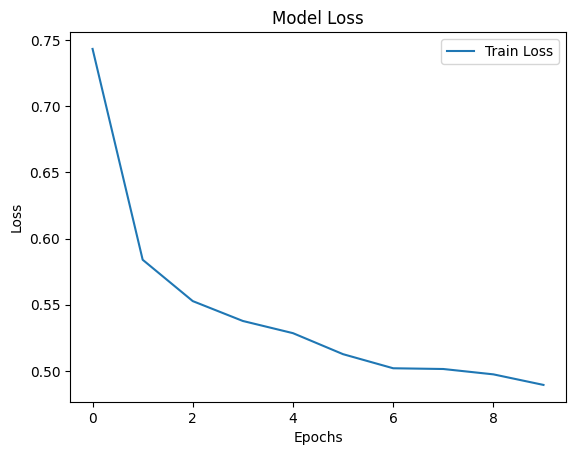

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

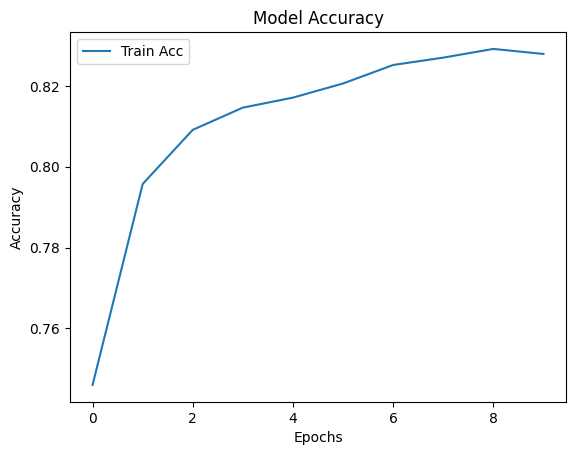

In [13]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [14]:
batch_size = 32

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Predict probabilities
y_pred_probs = model.predict(test_ds)

# Convert predictions and true labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# 📋 Classification Report
report = classification_report(y_true, y_pred, digits=2)
print("Classification Report:\n", report)